# Imports

In [1]:
import math
import inflection

import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image

## Read data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store')

## Helper funcions

In [3]:
 def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

In [4]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data description

In [5]:
df1 = df_raw.copy()

## Rename columns

In [6]:
# changing the name of the columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old) )

df1.columns = cols_new

## Data dimensions

In [7]:
df1.shape

(1017209, 18)

## Data types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## Fillout NA

In [10]:
# competition_distance              2642 NAs
# in this case we'll put a very large input to assume there is no competition near our store
max_value = df1['competition_distance'].max() * 3 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: max_value if math.isnan( x ) else x )


# competition_open_since_month    323348 NAs
# competition_open_since_year     323348 NAs
# we'll copy the month and year of the sale, because we don't have the real date
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] )
                                                 else x['competition_open_since_month'], axis=1 )

df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] )
                                                 else x['competition_open_since_year'], axis=1 )


# promo2_since_week               508031 NAs
# promo2_since_year               508031 NAs
# we'll use the same method as the competition open since x
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] )
                                                 else x['promo2_since_week'], axis=1 )

df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] )
                                                 else x['promo2_since_year'], axis=1 )

 
# promo_interval                  508031 NAs
# we'll map out the months, see if they're in the correct month for the promotion and create a new column saying if it is 
# in a promotion period or not with a boolean
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['promo_interval'].fillna( 0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] =  df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0
                                                               else 1 if x['month_map'] in x['promo_interval'].split ( ',' ) 
                                                               else 0, axis=1 )


In [11]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## Change dtypes

In [12]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## Descriptive statistics

In [14]:
num_attributes = df1.select_dtypes( include = ['int64', 'float64', 'int32'])
cat_attributes = df1.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]', 'int32'])

### Numerical Attributes

In [15]:
# central tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [16]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### Categorical Attributes

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

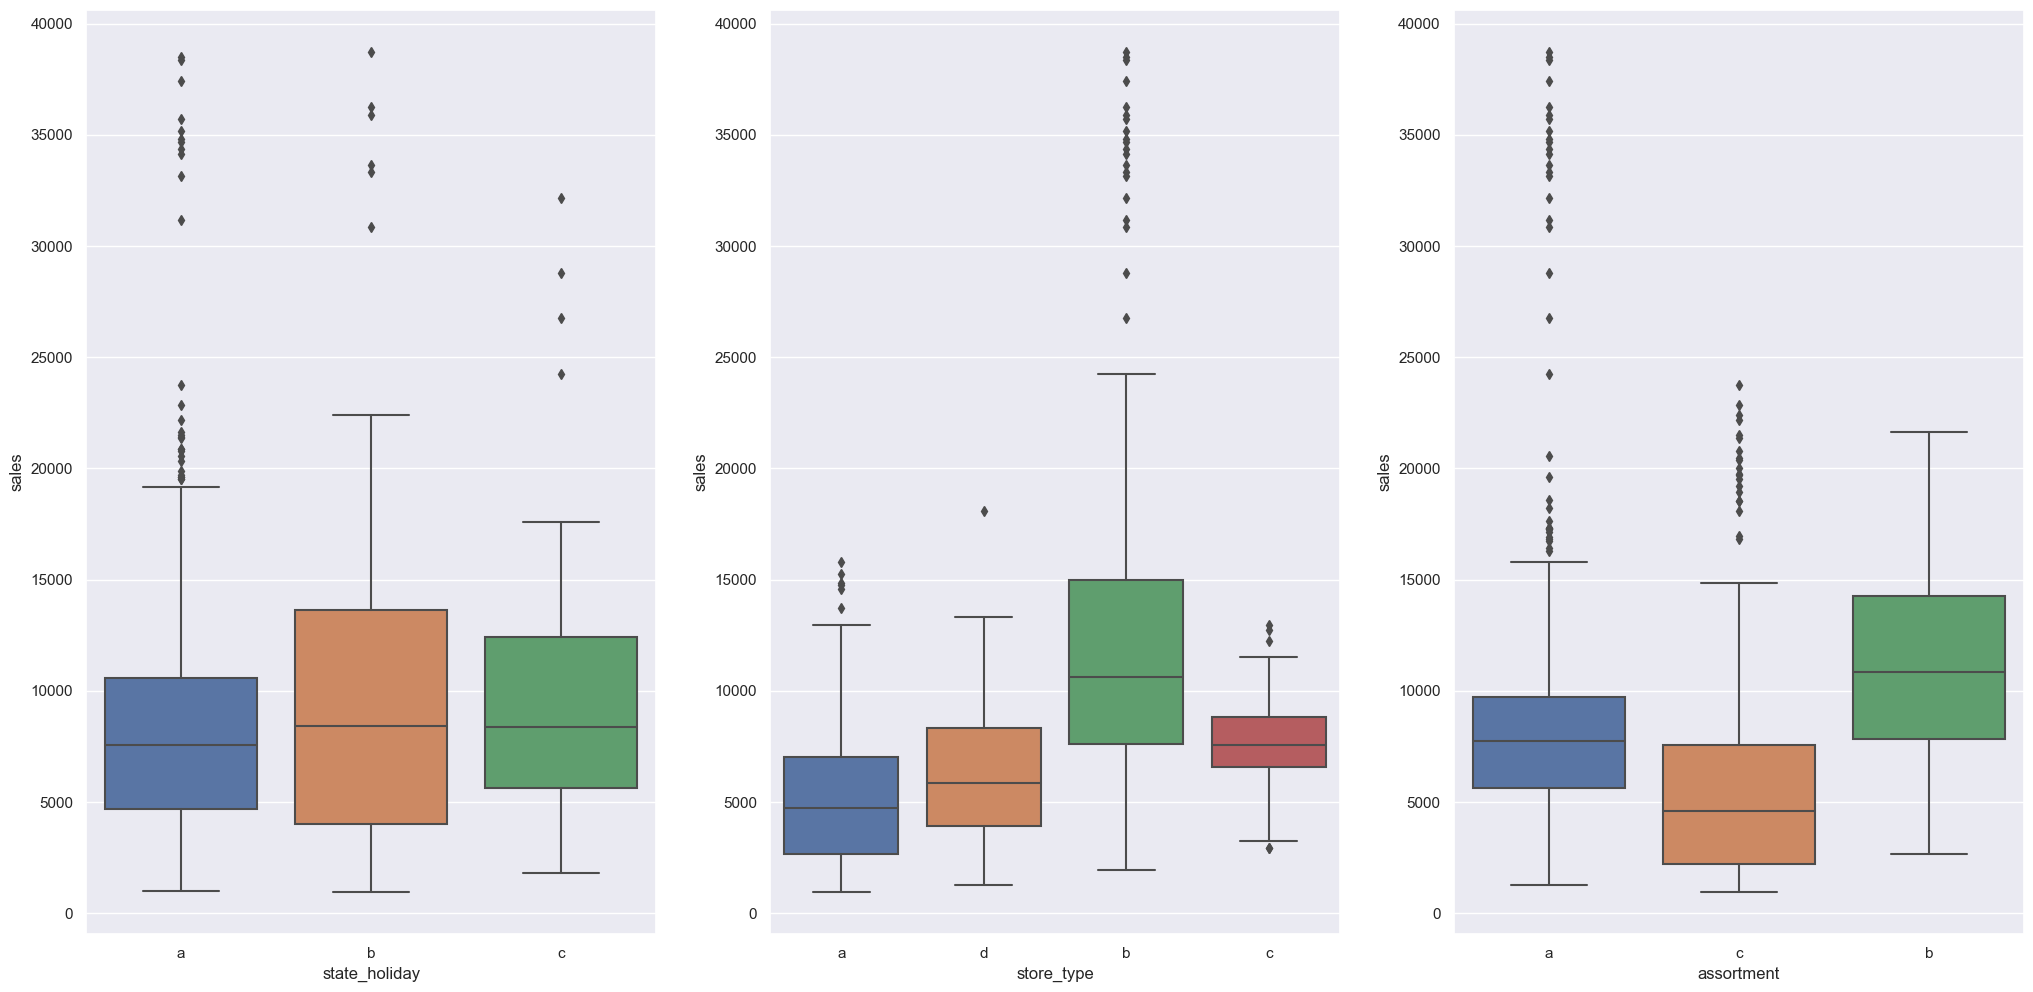

In [18]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x = 'state_holiday', y = 'sales', data = aux1 )

plt.subplot( 1, 3, 2 )
sns.boxplot( x = 'store_type', y = 'sales', data = aux1 )

plt.subplot( 1, 3, 3 )
sns.boxplot( x = 'assortment', y = 'sales', data = aux1 )

# Feature Engineering

Here we'll look at some assumptions and try to prove or disprove those hypothesis. 

First we have a mind map of what are some of our problem's possible variables.

## Creating some hypothesis

In [19]:
df2 = df1.copy()

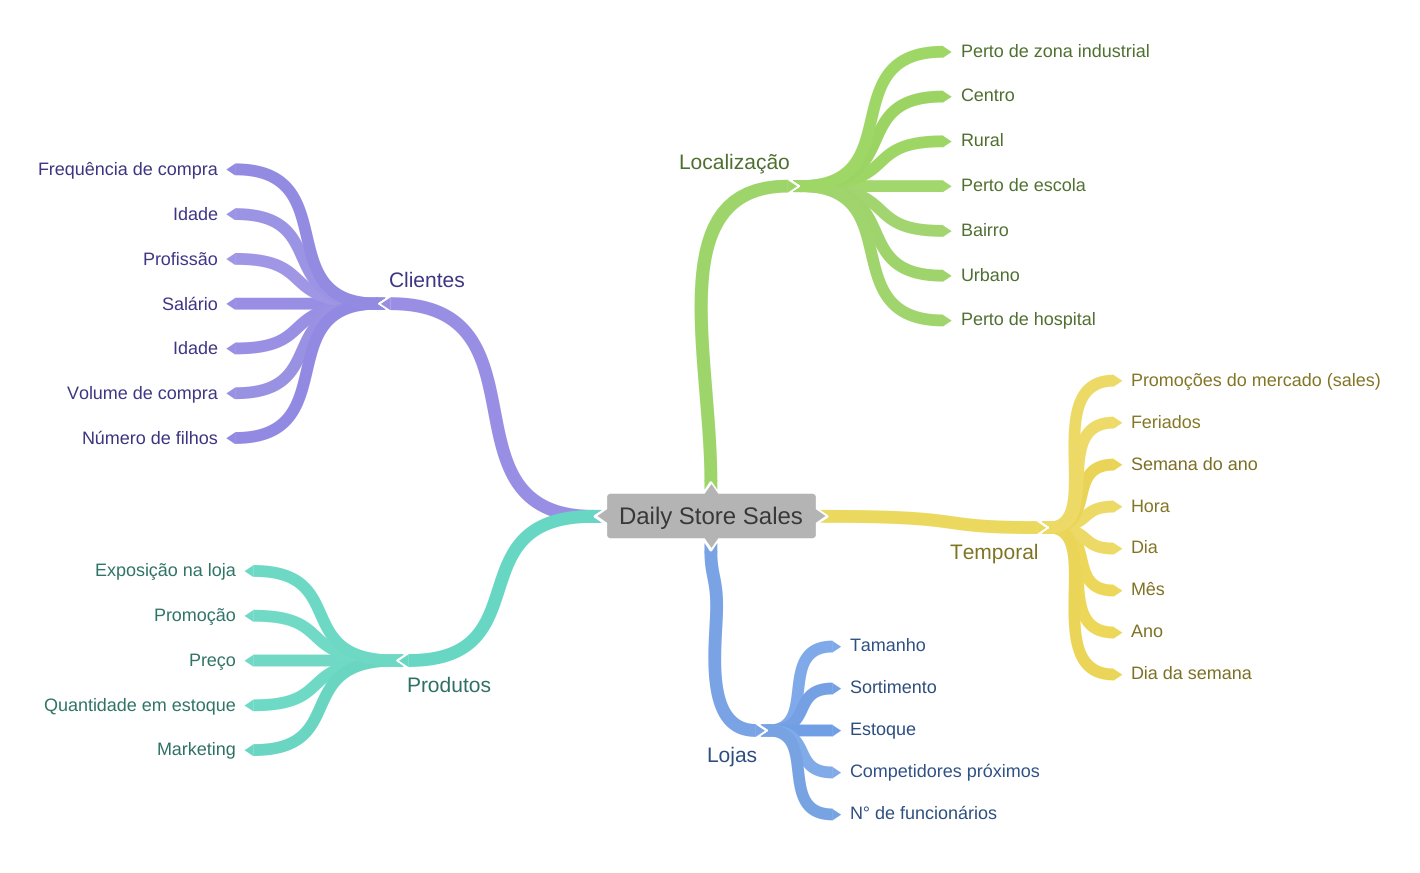

In [20]:
Image( 'img/daily_store_sales.png', width=950)

Now we'll look at what we assume based on these variables.

Hipoteses Loja
1. Lojas com número maior de funcionários deveriam vender mais.                          | não temos o número de funcionários
2. Lojas com maior capacidade de estoque deveriam vender mais.                           | não temos o tamanho do estoque
3. Lojas com maior porte deveriam vender mais.                                           | não temos o tamanho da loja
4. Lojas com maior sortimentos deveriam vender mais.                                     | ok
5. Lojas com competidores mais próximos deveriam vender menos.                           | ok
6. Lojas com competidores à mais tempo deveriam vendem mais.                             | ok

Hipoteses Produto
1. Lojas que investem mais em Marketing deveriam vender mais.                            | não temos valor de budget de marketing
2. Lojas com maior exposição de produto deveriam vender mais.                            | não temos dados sobre exposição do produto
3. Lojas com produtos com preço menor deveriam vender mais.                              | não temos dados de preço
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.      | não temos dados de preço
6. Lojas com promoções ativas por mais tempo deveriam vender mais.                       | ok
7. Lojas com mais dias de promoção deveriam vender mais.                                 | ok
8. Lojas com mais promoções consecutivas deveriam vender mais.                           | ok 

Hipoteses Tempo
1. Lojas abertas durante o feriado de Natal deveriam vender mais.                        | ok
2. Lojas deveriam vender mais ao longo dos anos.                                         | ok 
3. Lojas deveriam vender mais no segundo semestre do ano.                                | ok
4. Lojas deveriam vender mais depois do dia 10 de cada mês.                              | ok 
5. Lojas deveriam vender menos aos finais de semana.                                     | ok 
6. Lojas deveriam vender menos durante os feriados escolares.                            | ok

## Final list of hypothesis

Lista Final de Hipóteses
1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
7. Lojas com mais promoções consecutivas deveriam vender mais.
8. Lojas abertas durante o feriado de Natal deveriam vender mais.
9. Lojas deveriam vender mais ao longo dos anos.
10. Lojas deveriam vender mais no segundo semestre do ano.
11. Lojas deveriam vender mais depois do dia 10 de cada mês.
12. Lojas deveriam vender menos aos finais de semana.
13. Lojas deveriam vender menos durante os feriados escolares.

## Feature engineering

In [45]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1 ), axis = 1 )
df2['competition_age_months'] = ( ( df2['date'] - df2['competition_since'] ) / 30 ).apply( lambda x: x.days ).astype( int) 

# promo since
df2['promo_since']  = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str ) 
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w'  ) - datetime.timedelta( days = 7 ))
df2['promo_age_weeks'] = ( ( df2['date'] - df2['promo_since'] ) / 7 ).apply( lambda x: x.days ).astype( int) 

# assortment type
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' ) 

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' ) 

# Filtering the variables

In [38]:
df3 = df2.copy()

In [40]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,promo_since,promo_age_weeks
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,extended,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,extended,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,extended,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,extended,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,2015-07-27,0


## Filtering lines 

In [42]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## Selecting columns

In [44]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )